# Pipeline of Digits

This is a starting notebook for solving the "Pipeline of Digits" assignment.


This notebook was created by [Santiago L. Valdarrama](https://twitter.com/svpino) as part of the [Machine Learning School](https://www.ml.school) program.

Let's make sure we are running the latest version of the SakeMaker's SDK. **Restart the notebook** after you upgrade the library.

In [2]:
!pip install -q --upgrade pip
!pip install -q --upgrade awscli boto3
!pip install -q --upgrade PyYAML==6.0
!pip install -q --upgrade sagemaker==2.165.0
!pip show sagemaker

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.29.1 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
Name: sagemaker
Version: 2.165.0
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /usr/local/lib/python3.8/site-packages
Requires: attrs, boto3, cloudpickle, google-pasta, importlib-metadata, jsonschema, numpy, packaging, pandas, pathos, platformdirs, protobuf, protobuf3-to-dict, PyYAML, schema, smdebug-rulesconfig, tblib
Required-by: 


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import boto3
import sagemaker
import pandas as pd

from pathlib import Path

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sagemaker_session = sagemaker.session.Session()

## Creating the S3 Bucket

Let's create an S3 bucket where you will upload all the information generated by the pipeline. Make sure you set `BUCKET` to the name of the bucket you want to use. This name has to be unique.

If you want to create a bucket in a region other than `us-east-1`, use this command instead:

```
!aws s3api create-bucket --bucket $BUCKET --create-bucket-configuration LocationConstraint=$region
```

The `LocationConstraint` argument should specify the region where you want to create the bucket.

In [ ]:
BUCKET = "ml-school-gibran-2023-mnist"

# !aws s3api create-bucket --bucket $BUCKET --region us-east-2 --create-bucket-configuration LocationConstraint=us-east-2

## Loading the dataset

We have two CSV files containing the MNIST dataset. These files come from the [MNIST in CSV](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv) Kaggle dataset.

The `mnist_train.csv` file contains 60,000 training examples and labels. The `mnist_test.csv` contains 10,000 test examples and labels. Each row consists of 785 values: the first value is the label (a number from 0 to 9) and the remaining 784 values are the pixel values (a number from 0 to 255).

Let's extract the `dataset.tar.gz` file.

In [4]:
MNIST_FOLDER = "mnist"
DATASET_FOLDER = Path("dataset")

!tar -xvzf dataset.tar.gz --no-same-owner

dataset/
dataset/mnist_test.csv
dataset/mnist_train.csv


Let's load the first 10 rows of the test set.

In [6]:
df = pd.read_csv(DATASET_FOLDER / "mnist_train.csv", nrows=1000)
df_test = pd.read_csv(DATASET_FOLDER / "mnist_test.csv", nrows=1000)
df.head(10)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def col_reshape(raw, num_classes, hasLabel=True):
    IMG_ROWS = 28
    IMG_COLS = 28
    start_pixel = 0

    if (hasLabel):
        start_pixel = 1
        
    if (hasLabel):
        out_y = keras.utils.np_utils.to_categorical(raw.label, num_classes)
    else:
        out_y = None
        
    num_images = raw.shape[0]
    x_array = raw.values[:, start_pixel:]
    x_shaped_array = x_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    
    return out_x, out_y

In [8]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization

In [9]:
X, y = col_reshape(df, 10)

In [10]:
## 60k for train, 10k for test

## Uploading dataset to S3

In [11]:
S3_FILEPATH = f"s3://{BUCKET}/{MNIST_FOLDER}"


TRAIN_SET_S3_URI = sagemaker.s3.S3Uploader.upload(
    local_path=str(DATASET_FOLDER / "mnist_train.csv"), 
    desired_s3_uri=S3_FILEPATH,
)

TEST_SET_S3_URI = sagemaker.s3.S3Uploader.upload(
    local_path=str(DATASET_FOLDER / "mnist_test.csv"), 
    desired_s3_uri=S3_FILEPATH,
)

print(f"Train set S3 location: {TRAIN_SET_S3_URI}")
print(f"Test set S3 location: {TEST_SET_S3_URI}")

Train set S3 location: s3://ml-school-gibran-2023-mnist/mnist/mnist_train.csv
Test set S3 location: s3://ml-school-gibran-2023-mnist/mnist/mnist_test.csv


# Part 1 - Data Preprocessing

## Data Parameters 

In [12]:
import os
import numpy as np
import boto3
import json
import numpy as np
import argparse
import tempfile

from botocore.exceptions import ClientError
from sagemaker.inputs import FileSystemInput
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.processing import ScriptProcessor
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.parameters import ParameterInteger, ParameterString, ParameterFloat
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import CacheConfig

In [13]:
iam_client = boto3.client("iam")
sagemaker_client = boto3.client("sagemaker")
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sagemaker_session = sagemaker.session.Session()

In [14]:
%%writefile {DATASET_FOLDER}/preprocessor.py

import os
import numpy as np
import pandas as pd
import tempfile

from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pickle import dump

from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization



# This is the location where the SageMaker Processing job
# will save the input dataset.
BASE_DIRECTORY = "/opt/ml/processing"
DATA_FILEPATH = Path(BASE_DIRECTORY) / "input" / "mnist_train.csv"


def _save_splits(base_directory, train, validation, test):
    """
    One of the goals of this script is to output the three
    dataset splits. This function will save each of these
    splits to disk.
    """
    
    train_path = Path(base_directory) / "train" 
    validation_path = Path(base_directory) / "validation" 
    test_path = Path(base_directory) / "test"
    
    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)
    
    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(validation_path / "validation.csv", header=False, index=False)
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)
    

def _save_pipeline(base_directory, pipeline):
    """
    Saves the Scikit-Learn pipeline that we used to
    preprocess the data.
    """
    pipeline_path = Path(base_directory) / "pipeline"
    pipeline_path.mkdir(parents=True, exist_ok=True)
    dump(pipeline, open(pipeline_path / "pipeline.pkl", 'wb'))
    

def _save_classes(base_directory, classes):
    """
    Saves the list of classes from the dataset.
    """
    path = Path(base_directory) / "classes"
    path.mkdir(parents=True, exist_ok=True)
    
    print("CLASSES", np.asarray(classes))

    np.asarray(classes).tofile(path / "classes.csv", sep = ",") 
    

def _generate_baseline_dataset(split_name, base_directory, X, y):
    """
    To monitor the data and the quality of our model we need to compare the 
    production quality and results against a baseline. To create those baselines, 
    we need to use a dataset to compute statistics and constraints. That dataset
    should contain information in the same format as expected by the production
    endpoint. This function will generate a baseline dataset and save it to 
    disk so we can later use it.
    
    """
    baseline_path = Path(base_directory) / f"{split_name}-baseline" 
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = X.copy()
    
    # The baseline dataset needs a column containing the groundtruth.
    df["groundtruth"] = y
    df["groundtruth"] = df["groundtruth"].values.astype(str)
    
    # We will use the baseline dataset to generate baselines
    # for monitoring data and model quality. To simplify the process, 
    # we don't want to include any NaN rows.
    df = df.dropna()

    df.to_json(baseline_path / f"{split_name}-baseline.json", orient='records', lines=True)


## reshape columns from 784 to 28, 28, 1
def col_reshape(raw, num_classes, hasLabel=True):
    IMG_ROWS = 28
    IMG_COLS = 28
    start_pixel = 0

    if (hasLabel):
        start_pixel = 1
        
    if (hasLabel):
        out_y = keras.utils.np_utils.to_categorical(raw.label, num_classes)
    else:
        out_y = None
        
    num_images = raw.shape[0]
    x_array = raw.values[:, start_pixel:]
    x_shaped_array = x_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    
    return out_x, out_y
    
    
def preprocess(base_directory, data_filepath_train, data_filepath_test, target_var):
    """
    Preprocesses the supplied raw dataset and splits it into a train, validation,
    and a test set.
    """
    
    df_train = pd.read_csv(data_filepath_train)
    df_test = pd.read_csv(data_filepath_test)
    
    # parameters
    NUM_CLASSES = len(df_train.label.unique())
    
    X, y = col_reshape(df_train, NUM_CLASSES)
    X_test, y_test = col_reshape(df_test, NUM_CLASSES)

    columns = list((df_train.drop([target_var], axis=1)).columns)
    
    X, test = X.to_numpy(), X_test.to_numpy()
    
    np.random.shuffle(X)
    train, validation = np.split(X, [int(.8 * len(X))])
    
    X_train = pd.DataFrame(train, columns=columns)
    X_validation = pd.DataFrame(validation, columns=columns)
    X_test = pd.DataFrame(test, columns=columns)
    
    y_train = X_train[target_var]
    y_validation = X_validation[target_var]
    y_test = X_test[target_var]
    
    label_encoder = LabelEncoder()
    
    ## IMPORTANT - fit_transform vs transform only
    y_train = label_encoder.fit_transform(y_train)
    y_validation = label_encoder.transform(y_validation)
    y_test = label_encoder.transform(y_test)
    
    X_train.drop([target_var], axis=1, inplace=True)
    X_validation.drop([target_var], axis=1, inplace=True)
    X_test.drop([target_var], axis=1, inplace=True)

    # Let's generate a dataset that we can later use to compute
    # baseline statistics and constraints about the data that we
    # used to train our model.
    _generate_baseline_dataset("train", base_directory, X_train, y_train)
    
    # To generate baseline constraints about the quality of the
    # model's predictions, we will use the test set.
    _generate_baseline_dataset("test", base_directory, X_test, y_test)
    
    # Transform the data using the Scikit-Learn pipeline.
    X_train = preprocessor.fit_transform(X_train)
    X_validation = preprocessor.transform(X_validation)
    X_test = preprocessor.transform(X_test)
    
    train = np.concatenate((X_train, np.expand_dims(y_train, axis=1)), axis=1)
    validation = np.concatenate((X_validation, np.expand_dims(y_validation, axis=1)), axis=1)
    test = np.concatenate((X_test, np.expand_dims(y_test, axis=1)), axis=1)
    
    _save_splits(base_directory, train, validation, test)
    _save_pipeline(base_directory, pipeline=preprocessor)
    _save_classes(base_directory, label_encoder.classes_)
        

if __name__ == "__main__":
    preprocess(BASE_DIRECTORY, DATA_FILEPATH)


Overwriting dataset/preprocessor.py


## Step 2 - Testing the Preprocessing Script

In [16]:
# from dataset.preprocessor import preprocess

# with tempfile.TemporaryDirectory() as directory:
#     preprocess(
#         base_directory=directory, 
#         data_filepath_train=DATASET_FOLDER/"mnist_train.csv",
#         data_filepath_test=DATASET_FOLDER/"mnist_test.csv",
#         target_var='label'
#     )
    
#     print(f"Folders: {os.listdir(directory)}")

## Step 3 - Pipeline Configuration

In [20]:
train_dataset_location = ParameterString(name="train_dataset_location", 
                                         default_value=TRAIN_SET_S3_URI)

test_dataset_location = ParameterString(name="test_dataset_location",
                                        default_value=TEST_SET_S3_URI)

preprocessor_destination = ParameterString(
    name="preprocessor_destination",
    default_value=f"{S3_FILEPATH}/preprocessing",
)

train_dataset_baseline_destination = ParameterString(
    name="train_dataset_baseline_destination",
    default_value=f"{S3_FILEPATH}/preprocessing/baselines/train",
)

test_dataset_baseline_destination = ParameterString(
    name="test_dataset_baseline_destination",
    default_value=f"{S3_FILEPATH}/preprocessing/baselines/test",
)

In [18]:
cache_config = CacheConfig(
    enable_caching=True, 
    expire_after="15d"
)

In [23]:
sklearn_processor = SKLearnProcessor(
    base_job_name="mnist-preprocessing",
    framework_version="0.23-1",
    instance_type="ml.t3.medium",
    instance_count=1,
    role=role,
)

preprocess_data_step = ProcessingStep(
    name="preprocess-data",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=train_dataset_location, destination="/opt/ml/processing/train"),
        ProcessingInput(source=test_dataset_location, destination="/opt/ml/processing/test"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train", destination=preprocessor_destination),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation", destination=preprocessor_destination),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test", destination=preprocessor_destination),
        ProcessingOutput(output_name="pipeline", source="/opt/ml/processing/pipeline", destination=preprocessor_destination),
        ProcessingOutput(output_name="classes", source="/opt/ml/processing/classes", destination=preprocessor_destination),
        ProcessingOutput(output_name="train-baseline", source="/opt/ml/processing/train-baseline", destination=train_dataset_baseline_destination),
        ProcessingOutput(output_name="test-baseline", source="/opt/ml/processing/test-baseline", destination=test_dataset_baseline_destination),
    ],
    code=f"{DATASET_FOLDER}/preprocessor.py",
    cache_config=cache_config
)

In [26]:
session1_pipeline = Pipeline(
    name="mnist-session1-pipeline",
    parameters=[
        train_dataset_location, 
        test_dataset_location, 
        preprocessor_destination,
        train_dataset_baseline_destination,
        test_dataset_baseline_destination
    ],
    steps=[
        preprocess_data_step, 
    ]
)

In [27]:
session1_pipeline.upsert(role_arn=role)
execution = session1_pipeline.start()

# Part 2 - Model Training and Tuning

In [67]:
## source: https://www.kaggle.com/code/gpreda/simple-introduction-to-cnn-for-mnist-99-37

In [91]:
import numpy as np
import matplotlib.pyplot as plt

INFO:matplotlib.font_manager:generated new fontManager


In [93]:
df = pd.read_csv(DATASET_FOLDER / "mnist_train.csv", nrows=6000)
columns = list(df)

In [94]:
df = df.to_numpy()
np.random.shuffle(df)
train, validation = np.split(df, [int(.8 * len(X))])

In [95]:
X_train = pd.DataFrame(train, columns=columns)
X_val = pd.DataFrame(validation, columns=columns)

In [96]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization

X_train, y_train = col_reshape(X_train, 10)
X_val, y_val = col_reshape(X_val, 10)

In [97]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10

def modeling():
    # Model
    model = Sequential()
    # Add convolution 2D
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', padding="same",
            kernel_initializer='he_normal',input_shape=(IMG_ROWS, IMG_COLS, 1)))

    model.add(BatchNormalization())

    model.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # Add dropouts to the model
    model.add(Dropout(0.4))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation='relu'))
    # Add dropouts to the model
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    # Add dropouts to the model
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

In [98]:
model = modeling()

In [99]:
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [100]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 32)        25632     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 6, 6, 32)         

In [101]:
#Model
NO_EPOCHS = 100
PATIENCE = 20
VERBOSE = 1
BATCH_SIZE = 128

In [102]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_acc',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=NO_EPOCHS,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[earlystopper, checkpointer])

Epoch 1/100
7/7 [==============================] - 4s 411ms/step - loss: 2.2656 - accuracy: 0.1650 - val_loss: 2.2933 - val_accuracy: 0.1587


Epoch 2/100
7/7 [==============================] - 2s 339ms/step - loss: 2.1585 - accuracy: 0.2387 - val_loss: 2.2706 - val_accuracy: 0.2179


Epoch 3/100
7/7 [==============================] - 2s 326ms/step - loss: 2.0405 - accuracy: 0.2887 - val_loss: 2.2274 - val_accuracy: 0.3142


Epoch 4/100
7/7 [==============================] - 2s 332ms/step - loss: 1.9072 - accuracy: 0.3725 - val_loss: 2.1391 - val_accuracy: 0.4094


Epoch 5/100
7/7 [==============================] - 2s 337ms/step - loss: 1.8067 - accuracy: 0.3837 - val_loss: 2.0617 - val_accuracy: 0.3513


Epoch 6/100
7/7 [==============================] - 2s 328ms/step - loss: 1.6702 - accuracy: 0.4387 - val_loss: 2.0049 - val_accuracy: 0.3148


Epoch 7/100
7/7 [==============================] - 2s 326ms/step - loss: 1.5411 - accuracy: 0.4888 - val_loss: 1.9069 - val_accuracy: 0.3612


Epoch 8/100
7/7 [==============================] - 2s 324ms/step - loss: 1.3735 - accuracy: 0.5475 - val_loss: 1.8716 - val_accuracy: 0.3333


Epoch 9/100
7/7 [==============================] - 2s 331ms/step - loss: 1.2173 - accuracy: 0.6037 - val_loss: 1.9114 - val_accuracy: 0.2787


Epoch 10/100
7/7 [==============================] - 2s 334ms/step - loss: 1.0651 - accuracy: 0.6538 - val_loss: 2.0773 - val_accuracy: 0.1619


Epoch 11/100
7/7 [==============================] - 2s 335ms/step - loss: 0.9459 - accuracy: 0.7075 - val_loss: 2.0090 - val_accuracy: 0.2171


Epoch 12/100
7/7 [==============================] - 2s 327ms/step - loss: 0.8359 - accuracy: 0.7337 - val_loss: 2.4465 - val_accuracy: 0.1446


Epoch 13/100
7/7 [==============================] - 2s 322ms/step - loss: 0.7151 - accuracy: 0.7750 - val_loss: 2.3910 - val_accuracy: 0.1627


Epoch 14/100
7/7 [==============================] - 2s 329ms/step - loss: 0.6116 - accuracy: 0.8238 - val_loss: 2.3001 - val_accuracy: 0.2258


Epoch 15/100
7/7 [==============================] - 2s 337ms/step - loss: 0.5163 - accuracy: 0.8375 - val_loss: 2.5640 - val_accuracy: 0.1852


Epoch 16/100
7/7 [==============================] - 2s 332ms/step - loss: 0.4657 - accuracy: 0.8537 - val_loss: 2.7860 - val_accuracy: 0.1435


Epoch 17/100
7/7 [==============================] - 2s 322ms/step - loss: 0.4099 - accuracy: 0.8675 - val_loss: 3.2971 - val_accuracy: 0.1212


Epoch 18/100
7/7 [==============================] - 2s 329ms/step - loss: 0.3294 - accuracy: 0.8975 - val_loss: 3.5980 - val_accuracy: 0.1225


Epoch 19/100
7/7 [==============================] - 2s 328ms/step - loss: 0.3055 - accuracy: 0.9062 - val_loss: 3.6099 - val_accuracy: 0.1288


Epoch 20/100
7/7 [==============================] - 2s 330ms/step - loss: 0.2889 - accuracy: 0.9125 - val_loss: 3.8732 - val_accuracy: 0.1206


Epoch 21/100
7/7 [==============================] - 2s 335ms/step - loss: 0.2745 - accuracy: 0.9200 - val_loss: 4.1526 - val_accuracy: 0.1162


Epoch 22/100
7/7 [==============================] - 2s 381ms/step - loss: 0.2553 - accuracy: 0.9237 - val_loss: 5.2385 - val_accuracy: 0.1112


Epoch 23/100
7/7 [==============================] - 2s 336ms/step - loss: 0.2034 - accuracy: 0.9425 - val_loss: 3.9540 - val_accuracy: 0.1723


Epoch 24/100
7/7 [==============================] - 3s 497ms/step - loss: 0.1692 - accuracy: 0.9575 - val_loss: 3.4560 - val_accuracy: 0.2148


Epoch 25/100
7/7 [==============================] - 2s 338ms/step - loss: 0.1772 - accuracy: 0.9475 - val_loss: 3.6566 - val_accuracy: 0.1908


Epoch 26/100
7/7 [==============================] - 2s 324ms/step - loss: 0.1871 - accuracy: 0.9500 - val_loss: 3.4842 - val_accuracy: 0.2171


Epoch 27/100
7/7 [==============================] - 2s 330ms/step - loss: 0.1422 - accuracy: 0.9563 - val_loss: 3.6875 - val_accuracy: 0.1900


Epoch 28/100
7/7 [==============================] - 2s 327ms/step - loss: 0.1261 - accuracy: 0.9588 - val_loss: 3.4658 - val_accuracy: 0.2052


Epoch 29/100
7/7 [==============================] - 2s 340ms/step - loss: 0.1397 - accuracy: 0.9563 - val_loss: 2.8843 - val_accuracy: 0.2892


Epoch 30/100
7/7 [==============================] - 2s 325ms/step - loss: 0.1171 - accuracy: 0.9663 - val_loss: 2.9758 - val_accuracy: 0.2983


Epoch 31/100
7/7 [==============================] - 2s 325ms/step - loss: 0.1230 - accuracy: 0.9650 - val_loss: 3.0346 - val_accuracy: 0.3208


Epoch 32/100
7/7 [==============================] - 2s 331ms/step - loss: 0.0921 - accuracy: 0.9712 - val_loss: 2.5245 - val_accuracy: 0.4073


Epoch 33/100
7/7 [==============================] - 2s 327ms/step - loss: 0.1195 - accuracy: 0.9638 - val_loss: 1.9776 - val_accuracy: 0.5015


Epoch 34/100
7/7 [==============================] - 2s 335ms/step - loss: 0.0847 - accuracy: 0.9787 - val_loss: 2.2428 - val_accuracy: 0.4369


Epoch 35/100
7/7 [==============================] - 2s 327ms/step - loss: 0.0820 - accuracy: 0.9800 - val_loss: 2.0975 - val_accuracy: 0.4663


Epoch 36/100
7/7 [==============================] - 2s 327ms/step - loss: 0.1037 - accuracy: 0.9725 - val_loss: 1.9919 - val_accuracy: 0.5015


Epoch 37/100
7/7 [==============================] - 2s 328ms/step - loss: 0.0896 - accuracy: 0.9762 - val_loss: 1.9318 - val_accuracy: 0.5298


Epoch 38/100
7/7 [==============================] - 2s 330ms/step - loss: 0.0936 - accuracy: 0.9750 - val_loss: 1.1297 - val_accuracy: 0.6992


Epoch 39/100
7/7 [==============================] - 2s 339ms/step - loss: 0.0934 - accuracy: 0.9650 - val_loss: 1.0527 - val_accuracy: 0.7273


Epoch 40/100
7/7 [==============================] - 2s 325ms/step - loss: 0.0632 - accuracy: 0.9837 - val_loss: 1.0087 - val_accuracy: 0.7469


Epoch 41/100
7/7 [==============================] - 2s 329ms/step - loss: 0.0843 - accuracy: 0.9762 - val_loss: 1.2977 - val_accuracy: 0.6775


Epoch 42/100
7/7 [==============================] - 2s 342ms/step - loss: 0.0810 - accuracy: 0.9825 - val_loss: 1.5677 - val_accuracy: 0.6127


Epoch 43/100
7/7 [==============================] - 2s 334ms/step - loss: 0.0694 - accuracy: 0.9775 - val_loss: 0.7275 - val_accuracy: 0.8110


Epoch 44/100
7/7 [==============================] - 2s 326ms/step - loss: 0.0629 - accuracy: 0.9812 - val_loss: 0.5797 - val_accuracy: 0.8488


Epoch 45/100
7/7 [==============================] - 2s 324ms/step - loss: 0.0687 - accuracy: 0.9800 - val_loss: 0.6133 - val_accuracy: 0.8363


Epoch 46/100
7/7 [==============================] - 2s 328ms/step - loss: 0.0682 - accuracy: 0.9837 - val_loss: 0.8154 - val_accuracy: 0.8131


Epoch 47/100
7/7 [==============================] - 2s 325ms/step - loss: 0.0541 - accuracy: 0.9837 - val_loss: 0.7751 - val_accuracy: 0.8187


Epoch 48/100
7/7 [==============================] - 2s 338ms/step - loss: 0.0766 - accuracy: 0.9737 - val_loss: 0.5652 - val_accuracy: 0.8558


Epoch 49/100
7/7 [==============================] - 2s 331ms/step - loss: 0.0511 - accuracy: 0.9887 - val_loss: 0.4561 - val_accuracy: 0.8837


Epoch 50/100
7/7 [==============================] - 2s 325ms/step - loss: 0.0485 - accuracy: 0.9837 - val_loss: 0.4547 - val_accuracy: 0.8848


Epoch 51/100
7/7 [==============================] - 2s 332ms/step - loss: 0.0619 - accuracy: 0.9812 - val_loss: 0.5331 - val_accuracy: 0.8658


Epoch 52/100
7/7 [==============================] - 3s 536ms/step - loss: 0.0552 - accuracy: 0.9800 - val_loss: 0.5785 - val_accuracy: 0.8569


Epoch 53/100
7/7 [==============================] - 2s 344ms/step - loss: 0.0524 - accuracy: 0.9837 - val_loss: 0.5046 - val_accuracy: 0.8725


Epoch 54/100
7/7 [==============================] - 2s 323ms/step - loss: 0.0438 - accuracy: 0.9862 - val_loss: 0.3901 - val_accuracy: 0.9021


Epoch 55/100
7/7 [==============================] - 2s 332ms/step - loss: 0.0565 - accuracy: 0.9812 - val_loss: 0.3408 - val_accuracy: 0.9140


Epoch 56/100
7/7 [==============================] - 2s 327ms/step - loss: 0.0539 - accuracy: 0.9812 - val_loss: 0.3416 - val_accuracy: 0.9127


Epoch 57/100
7/7 [==============================] - 2s 339ms/step - loss: 0.0729 - accuracy: 0.9812 - val_loss: 0.2879 - val_accuracy: 0.9227


Epoch 58/100
7/7 [==============================] - 2s 328ms/step - loss: 0.0656 - accuracy: 0.9750 - val_loss: 0.2712 - val_accuracy: 0.9331


Epoch 59/100
7/7 [==============================] - 2s 324ms/step - loss: 0.0594 - accuracy: 0.9775 - val_loss: 0.2661 - val_accuracy: 0.9388


Epoch 60/100
7/7 [==============================] - 2s 328ms/step - loss: 0.0645 - accuracy: 0.9825 - val_loss: 0.2969 - val_accuracy: 0.9333


Epoch 61/100
7/7 [==============================] - 2s 325ms/step - loss: 0.0691 - accuracy: 0.9750 - val_loss: 0.3044 - val_accuracy: 0.9342


Epoch 62/100
7/7 [==============================] - 2s 339ms/step - loss: 0.0466 - accuracy: 0.9862 - val_loss: 0.3019 - val_accuracy: 0.9342


Epoch 63/100
7/7 [==============================] - 2s 325ms/step - loss: 0.0380 - accuracy: 0.9887 - val_loss: 0.3110 - val_accuracy: 0.9288


Epoch 64/100
7/7 [==============================] - 2s 331ms/step - loss: 0.0484 - accuracy: 0.9850 - val_loss: 0.3074 - val_accuracy: 0.9300


Epoch 65/100
7/7 [==============================] - 2s 326ms/step - loss: 0.0519 - accuracy: 0.9862 - val_loss: 0.2947 - val_accuracy: 0.9331


Epoch 66/100
7/7 [==============================] - 2s 324ms/step - loss: 0.0478 - accuracy: 0.9887 - val_loss: 0.3118 - val_accuracy: 0.9323


Epoch 67/100
7/7 [==============================] - 2s 345ms/step - loss: 0.0379 - accuracy: 0.9887 - val_loss: 0.3022 - val_accuracy: 0.9344


Epoch 68/100
7/7 [==============================] - 2s 324ms/step - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.2822 - val_accuracy: 0.9375


Epoch 69/100
7/7 [==============================] - 2s 330ms/step - loss: 0.0281 - accuracy: 0.9950 - val_loss: 0.2686 - val_accuracy: 0.9437


Epoch 70/100
7/7 [==============================] - 2s 324ms/step - loss: 0.0403 - accuracy: 0.9862 - val_loss: 0.2877 - val_accuracy: 0.9358


Epoch 71/100
7/7 [==============================] - 2s 331ms/step - loss: 0.0270 - accuracy: 0.9925 - val_loss: 0.2890 - val_accuracy: 0.9365


Epoch 72/100
7/7 [==============================] - 2s 361ms/step - loss: 0.0353 - accuracy: 0.9912 - val_loss: 0.3039 - val_accuracy: 0.9308


Epoch 73/100
7/7 [==============================] - 2s 326ms/step - loss: 0.0362 - accuracy: 0.9912 - val_loss: 0.2994 - val_accuracy: 0.9350


Epoch 74/100
7/7 [==============================] - 2s 332ms/step - loss: 0.0379 - accuracy: 0.9912 - val_loss: 0.2874 - val_accuracy: 0.9377


Epoch 75/100
7/7 [==============================] - 2s 325ms/step - loss: 0.0401 - accuracy: 0.9900 - val_loss: 0.2800 - val_accuracy: 0.9413


Epoch 76/100
7/7 [==============================] - 2s 331ms/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 0.2639 - val_accuracy: 0.9446


Epoch 77/100
7/7 [==============================] - 2s 337ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.2801 - val_accuracy: 0.9419


Epoch 78/100
7/7 [==============================] - 2s 329ms/step - loss: 0.0233 - accuracy: 0.9950 - val_loss: 0.3064 - val_accuracy: 0.9388


Epoch 79/100
7/7 [==============================] - 2s 329ms/step - loss: 0.0362 - accuracy: 0.9875 - val_loss: 0.2857 - val_accuracy: 0.9435


Epoch 80/100
7/7 [==============================] - 3s 442ms/step - loss: 0.0342 - accuracy: 0.9912 - val_loss: 0.2572 - val_accuracy: 0.9473


Epoch 81/100
7/7 [==============================] - 3s 401ms/step - loss: 0.0307 - accuracy: 0.9937 - val_loss: 0.2476 - val_accuracy: 0.9477


Epoch 82/100
7/7 [==============================] - 2s 324ms/step - loss: 0.0256 - accuracy: 0.9925 - val_loss: 0.2515 - val_accuracy: 0.9456


Epoch 83/100
7/7 [==============================] - 2s 332ms/step - loss: 0.0515 - accuracy: 0.9812 - val_loss: 0.2459 - val_accuracy: 0.9471


Epoch 84/100
7/7 [==============================] - 2s 326ms/step - loss: 0.0277 - accuracy: 0.9912 - val_loss: 0.2489 - val_accuracy: 0.9506


Epoch 85/100
7/7 [==============================] - 2s 333ms/step - loss: 0.0250 - accuracy: 0.9912 - val_loss: 0.2565 - val_accuracy: 0.9490


Epoch 86/100
7/7 [==============================] - 2s 335ms/step - loss: 0.0165 - accuracy: 0.9962 - val_loss: 0.2574 - val_accuracy: 0.9508


Epoch 87/100
7/7 [==============================] - 2s 330ms/step - loss: 0.0329 - accuracy: 0.9912 - val_loss: 0.2576 - val_accuracy: 0.9515


Epoch 88/100
7/7 [==============================] - 2s 324ms/step - loss: 0.0272 - accuracy: 0.9937 - val_loss: 0.2564 - val_accuracy: 0.9517


Epoch 89/100
7/7 [==============================] - 2s 323ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.2465 - val_accuracy: 0.9546


Epoch 90/100
7/7 [==============================] - 2s 331ms/step - loss: 0.0313 - accuracy: 0.9912 - val_loss: 0.2461 - val_accuracy: 0.9531


Epoch 91/100
7/7 [==============================] - 2s 336ms/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.2562 - val_accuracy: 0.9498


Epoch 92/100
7/7 [==============================] - 2s 331ms/step - loss: 0.0180 - accuracy: 0.9950 - val_loss: 0.2839 - val_accuracy: 0.9431


Epoch 93/100
7/7 [==============================] - 2s 327ms/step - loss: 0.0214 - accuracy: 0.9925 - val_loss: 0.2870 - val_accuracy: 0.9402


Epoch 94/100
7/7 [==============================] - 2s 325ms/step - loss: 0.0250 - accuracy: 0.9900 - val_loss: 0.2869 - val_accuracy: 0.9415


Epoch 95/100
7/7 [==============================] - 2s 350ms/step - loss: 0.0278 - accuracy: 0.9912 - val_loss: 0.3191 - val_accuracy: 0.9329


Epoch 96/100
7/7 [==============================] - 2s 334ms/step - loss: 0.0311 - accuracy: 0.9925 - val_loss: 0.3220 - val_accuracy: 0.9342


Epoch 97/100
7/7 [==============================] - 2s 331ms/step - loss: 0.0263 - accuracy: 0.9925 - val_loss: 0.2989 - val_accuracy: 0.9365


Epoch 00097: early stopping


In [103]:
history.history

{'loss': [2.2656495571136475,
  2.1584877967834473,
  2.040471315383911,
  1.9071776866912842,
  1.8066881895065308,
  1.6701576709747314,
  1.5410516262054443,
  1.3734877109527588,
  1.2172600030899048,
  1.0650876760482788,
  0.9458809494972229,
  0.8358756303787231,
  0.7150549292564392,
  0.611640214920044,
  0.5162917971611023,
  0.4657489061355591,
  0.4099295139312744,
  0.3294370770454407,
  0.3054705560207367,
  0.28892067074775696,
  0.2745261788368225,
  0.25525030493736267,
  0.203445166349411,
  0.1691737174987793,
  0.17724500596523285,
  0.18709148466587067,
  0.1421828418970108,
  0.12608444690704346,
  0.13968366384506226,
  0.1170697957277298,
  0.12300405651330948,
  0.09212538599967957,
  0.11954484134912491,
  0.0846906304359436,
  0.08201109617948532,
  0.10367272049188614,
  0.08963456749916077,
  0.09356426447629929,
  0.0934014767408371,
  0.06322778016328812,
  0.08429780602455139,
  0.08101370185613632,
  0.06941109895706177,
  0.06286761909723282,
  0.06868

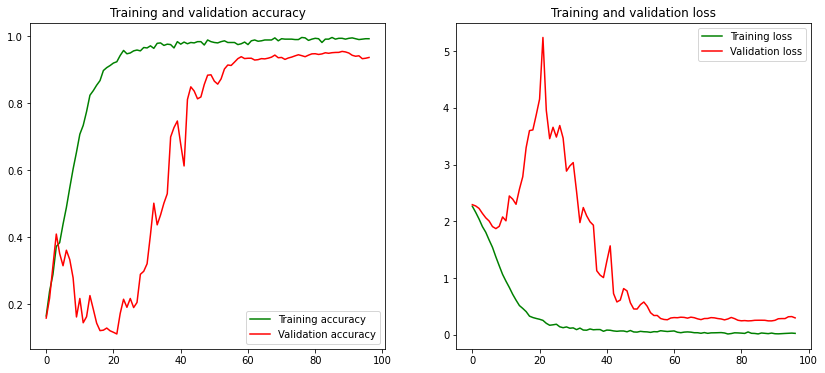

In [104]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
    
plot_accuracy_and_loss(history)

In [113]:
print("run model - predict validation set")
score = model.evaluate(X_val, y_val, verbose=0)
print(f'Last validation loss: {score[0]}, accuracy: {score[1]}')
# load saved optimal model
# model_optimal = model
# model_optimal.load_weights(checkpointer.model.weights)
# score = model_optimal.evaluate(X_val, y_val, verbose=0)
# print(f'Best validation loss: {score[0]}, accuracy: {score[1]}')

run model - predict validation set
Last validation loss: 0.2989058494567871, accuracy: 0.9365384578704834


In [114]:
def predict_show_classes(model, X_val, y_val):
    #get the predictions for the test data
    predicted_classes = model.predict_classes(X_val)
    #get the indices to be plotted
    y_true = np.argmax(y_val,axis=1)
    correct = np.nonzero(predicted_classes==y_true)[0]
    incorrect = np.nonzero(predicted_classes!=y_true)[0]
    print("Correct predicted classes:",correct.shape[0])
    print("Incorrect predicted classes:",incorrect.shape[0])
    target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
    print(classification_report(y_true, predicted_classes, target_names=target_names))
    return correct, incorrect

In [116]:
from sklearn.metrics import classification_report

In [117]:
correct, incorrect = predict_show_classes(model, X_val, y_val)

/usr/local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Correct predicted classes: 4870
Incorrect predicted classes: 330
              precision    recall  f1-score   support

    Class 0:       0.93      0.97      0.95       518
    Class 1:       0.90      0.98      0.94       578
    Class 2:       0.92      0.90      0.91       492
    Class 3:       0.97      0.92      0.95       533
    Class 4:       0.93      0.96      0.94       543
    Class 5:       0.95      0.94      0.95       451
    Class 6:       0.92      0.97      0.94       524
    Class 7:       0.93      0.97      0.95       562
    Class 8:       0.97      0.91      0.94       467
    Class 9:       0.98      0.84      0.90       532

    accuracy                           0.94      5200
   macro avg       0.94      0.94      0.94      5200
weighted avg       0.94      0.94      0.94      5200

